Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Modular Patch Inference

The core to a modular patch inference is `monai.inferer.PatchInferer`. It employs and coordinates different pieces to provide flexibility and extensibility for patch-wise inference and merging their results to create a merged output. The diagram below demonstrates how different pieces works together: 
- `Splitter`, which handles splitting the inputs into patches with different strategies (e.g., sliding window)
- `Merger`, which takes care of aggregating the patch outputs and merging them based on different ways to fuse the overlaps (e.g., averaging).
- Inference pipeline, which provides options for preprocessing and postprocessing of each individual patch in addition to run the deep learning network inference.
- Batch sampler, which ensure an efficient way to provide a batch of patches into the inference pipeline.

![PatchInferer](../figures/patch_inferer.jpg)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow,tqdm,cucim,zarr]"
!python -c "import zarr" || pip install -q zarr
!python -c "import matplotlib" || pip install -q matplotlib

## Setup imports

In [2]:
import os

import torch
import zarr
from matplotlib import pyplot as plt
from monai.apps import download_url
from monai.config import print_config
from monai.data import Dataset, DataLoader, PILReader, WSIReader
from monai.inferers import AvgMerger, PatchInferer, SlidingWindowSplitter, WSISlidingWindowSplitter, ZarrAvgMerger
from monai.transforms import LoadImage, Compose, EnsureChannelFirst, AsChannelLast

print_config()

MONAI version: 1.2.0+36.g6c231eaa
Numpy version: 1.25.0
Pytorch version: 2.0.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 6c231eaa48348557abbac82e6bd9f42d0734deb4
MONAI __file__: /Users/bhashemian/workspace/project-monai/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.21.0
Pillow version: 9.5.0
Tensorboard version: 2.13.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installi

### Auxiliary functions

In [3]:
def plot_limit_axis(ax, img, xlim, ylim):
    ax.imshow(AsChannelLast()(img[0]).to(torch.uint8))
    ax.set_xlim([0, xlim])
    ax.set_ylim([ylim, 0])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])


def network_random_brightness(img):
    return img * (torch.rand(1) + 1) * 0.5


def run_inference(inferer, network, filenames, transform=None):
    dataset = Dataset(filenames, transform=transform)
    outputs = []
    for inputs in DataLoader(dataset):
        out = inferer(inputs, network)
        outputs.append(out)
    return outputs

## Sliding Window Patch Inference
Inference of images by splitting them into patches using sliding window and merging the patches to build the inference result for the entire image.

In [4]:
# Plot aux function
def cat_plot(ax, img):
    plot_limit_axis(ax, img, 512, 640)


# Download the image and create file path list
IMAGE_URLS = ["https://github.com/Project-MONAI/MONAI/raw/dev/tests/testing_data/kitty_test.jpg"]
IMAGE_PATH_LIST = []
for url in IMAGE_URLS:
    path = os.path.join(os.path.abspath("."), os.path.basename(url))
    download_url(url, path)
    IMAGE_PATH_LIST.append(path)

# Transforms
transforms = Compose([LoadImage(reader=PILReader, reverse_indexing=False, image_only=True), EnsureChannelFirst()])

# Load input image (for plotting purposes only)
IMAGE = transforms(IMAGE_PATH_LIST)

2023-07-03 11:01:02,038 - INFO - Expected md5 is None, skip md5 check for file /Users/bhashemian/workspace/project-monai/tutorials/patch_inferer/kitty_test.jpg.
2023-07-03 11:01:02,038 - INFO - File exists: /Users/bhashemian/workspace/project-monai/tutorials/patch_inferer/kitty_test.jpg, skipped downloading.


### Effect of overlap

Text(0.5, 0.98, 'Effect of overlap (without padding, patch_size=64)')

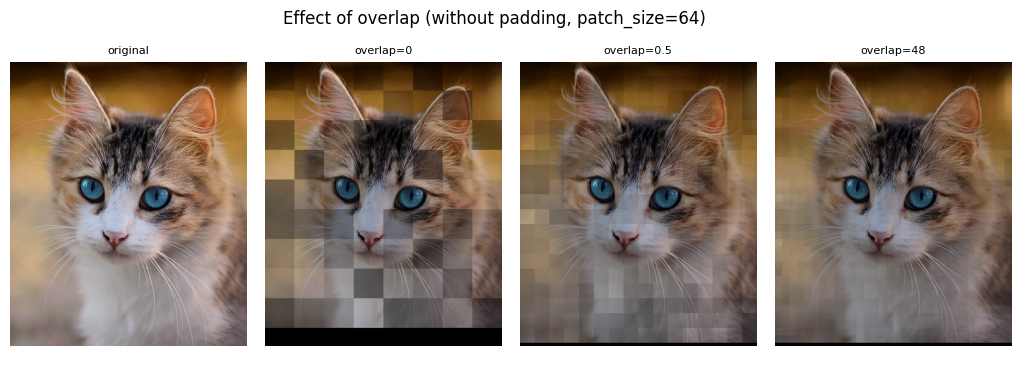

In [5]:
patch_size = 64
overlaps = [0, 0.5, 48]
nrows = 1
ncols = len(overlaps) + 1
figsize = (3 * ncols + 1, 4 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.85)
cat_plot(axes[0], IMAGE)
axes[0].set_title("original", fontsize=8)
for i, overlap in enumerate(overlaps, 1):
    inferer = PatchInferer(
        splitter=SlidingWindowSplitter(patch_size=patch_size, overlap=overlap, pad_mode=None),
        merger_cls=AvgMerger,
        match_spatial_shape=False,
    )
    img = run_inference(inferer, network_random_brightness, IMAGE_PATH_LIST, transforms)
    cat_plot(axes[i], img[0])
    axes[i].set_title(f"{overlap=}", fontsize=8)

fig.suptitle(f"Effect of overlap (without padding, {patch_size=})", fontsize=12)

### Effect of padding and matching spatial shape

Text(0.5, 0.98, ' Effect of padding and matching spatial shape (without overlap, patch_size=64)')

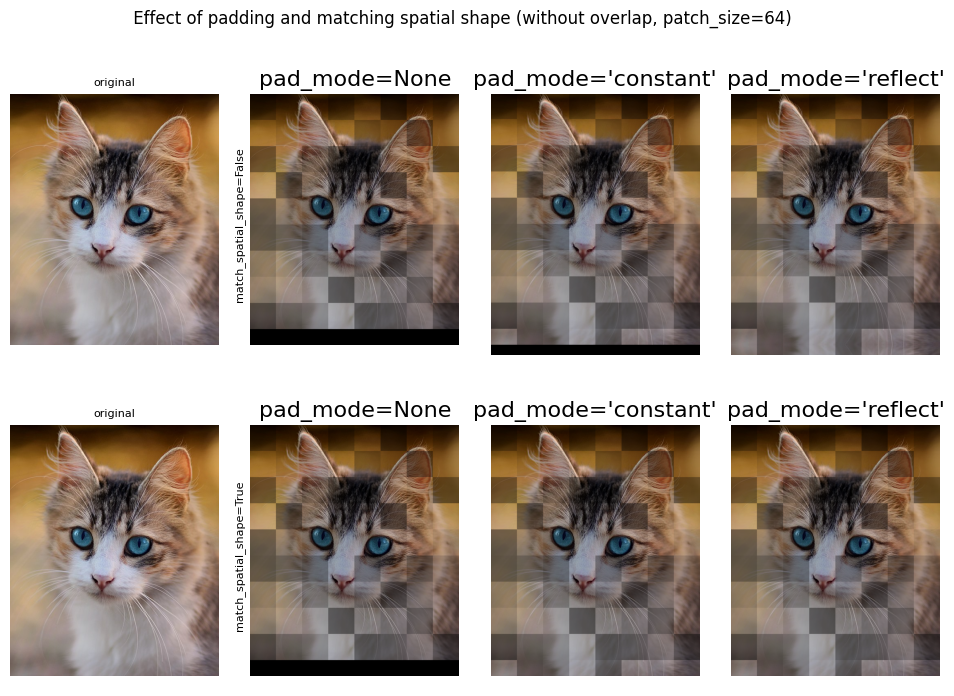

In [6]:
match_spatial_shapes = [False, True]
pad_modes = [None, "constant", "reflect"]
nrows = len(match_spatial_shapes)
ncols = len(pad_modes) + 1
figsize = (3 * ncols, 4 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.15, hspace=0.1, top=0.9)
cat_plot(axes[0, 0], IMAGE)
cat_plot(axes[1, 0], IMAGE)
axes[0, 0].set_title("original", fontsize=8)
axes[1, 0].set_title("original", fontsize=8)
for i, match_spatial_shape in enumerate(match_spatial_shapes):
    for j, pad_mode in enumerate(pad_modes, 1):
        inferer = PatchInferer(
            splitter=SlidingWindowSplitter(patch_size=patch_size, pad_mode=pad_mode),
            merger_cls=AvgMerger,
            match_spatial_shape=match_spatial_shape,
        )
        img = run_inference(inferer, network_random_brightness, IMAGE_PATH_LIST, transforms)
        ax = axes[i, j]
        cat_plot(ax, img[0])
        ax.set_title(f"{pad_mode=}", fontsize=16)
        if j == 1:
            ax.set_ylabel(f"{match_spatial_shape=}", fontsize=8)
fig.suptitle(f" Effect of padding and matching spatial shape (without overlap, {patch_size=})", fontsize=12)

## WSI Sliding Window Patch Inference
Inference of whole slide images by splitting them into patches using sliding window (without loading the entire image into memory and merging) the patches to build the inference result for the entire image.

In [7]:
# Plot aux function
def wsi_plot(ax, img):
    plot_limit_axis(ax, img, 800, 600)


# Download whole slide images and create file path list
wsi_keys = ["wsi_generic_tiff"]
wsi_urls = ["https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/CMU-1.tiff"]
wsi_hash_vals = ["73a7e89bc15576587c3d68e55d9bf92f09690280166240b48ff4b48230b13bcd"]
WSI_PATH_LIST = []
for key, url, hash in zip(wsi_keys, wsi_urls, wsi_hash_vals):
    path = os.path.join(os.path.abspath("."), f"temp_{key}.tiff")
    download_url(url, path, hash_type="sha256", hash_val=hash)
    WSI_PATH_LIST.append(path)

# WSI Reader backend
WSI_BACKEND = "cucim"

# The level at which image should be loaded
WSI_LEVEL = 6

# Load input WSI (for plotting purposes only)
WSI_IMAGE = LoadImage(reader=WSIReader, backend=WSI_BACKEND, level=WSI_LEVEL, image_only=True)(WSI_PATH_LIST)
WSI_IMAGE = WSI_IMAGE[None, ...]

2023-07-03 11:01:03,161 - INFO - Verified 'temp_wsi_generic_tiff.tiff', sha256: 73a7e89bc15576587c3d68e55d9bf92f09690280166240b48ff4b48230b13bcd.
2023-07-03 11:01:03,161 - INFO - File exists: /Users/bhashemian/workspace/project-monai/tutorials/patch_inferer/temp_wsi_generic_tiff.tiff, skipped downloading.


### Effect of overlap

Text(0.5, 0.98, 'Effect of overlap (without padding, patch_size=64)')

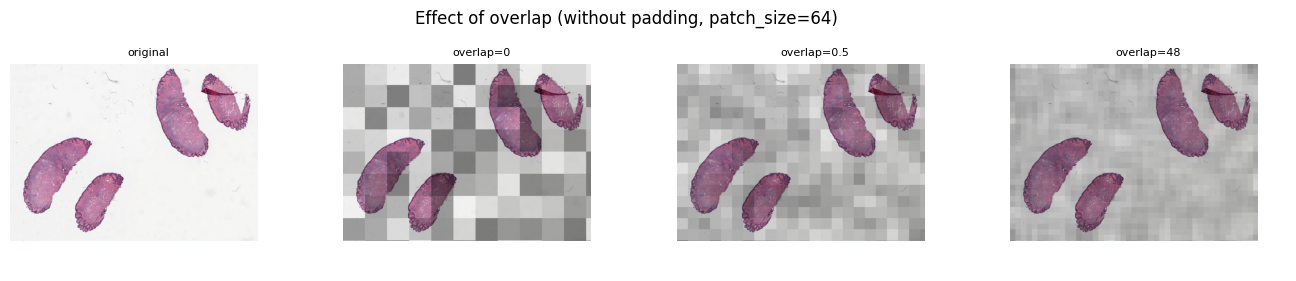

In [8]:
patch_size = 64
overlaps = [0, 0.5, 48]
nrows = 1
ncols = len(overlaps) + 1
figsize = (4 * ncols + 1, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.8)
wsi_plot(axes[0], WSI_IMAGE)
axes[0].set_title("original", fontsize=8)
for i, overlap in enumerate(overlaps, start=1):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(patch_size=patch_size, overlap=overlap, reader=WSI_BACKEND, level=WSI_LEVEL),
        merger_cls=AvgMerger,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"{overlap=}", fontsize=8)

fig.suptitle(f"Effect of overlap (without padding, {patch_size=})", fontsize=12)

### Effect of padding and matching spatial shape

Text(0.5, 0.98, ' Effect of padding and matching spatial shapes (without overlap, patch_size=64)')

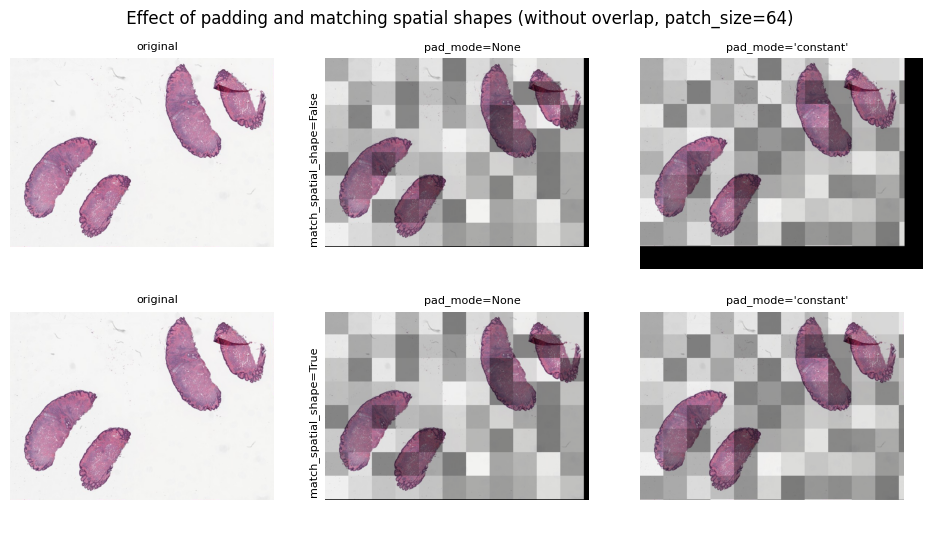

In [9]:
match_spatial_shapes = [False, True]
pad_modes = [None, "constant"]
nrows = len(match_spatial_shapes)
ncols = len(pad_modes) + 1
figsize = (4 * ncols, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, hspace=0.15, top=0.9)
wsi_plot(axes[0, 0], WSI_IMAGE)
wsi_plot(axes[1, 0], WSI_IMAGE)
axes[0, 0].set_title("original", fontsize=8)
axes[1, 0].set_title("original", fontsize=8)
for i, match_spatial_shape in enumerate(match_spatial_shapes):
    for j, pad_mode in enumerate(pad_modes, start=1):
        inferer = PatchInferer(
            splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode=pad_mode, reader=WSI_BACKEND, level=6),
            merger_cls=AvgMerger,
            match_spatial_shape=match_spatial_shape,
        )
        img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
        ax = axes[i, j]
        wsi_plot(ax, img[0])
        ax.set_title(f"{pad_mode=}", fontsize=8)
        if j == 1:
            ax.set_ylabel(f"{match_spatial_shape=}", fontsize=8)
fig.suptitle(f" Effect of padding and matching spatial shapes (without overlap, {patch_size=})", fontsize=12)

### Effect of filtering patches

Text(0.5, 0.98, 'Patch filtering by a threshold (effect of different patch sizes)')

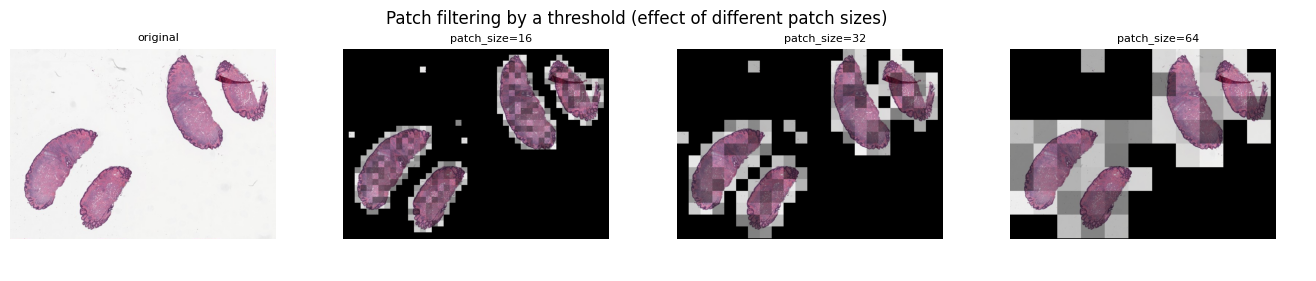

In [10]:
def filter_fn(patch, loc):
    return patch.min() < 130


patch_sizes = [16, 32, 64]
nrows = 1
ncols = len(patch_sizes) + 1
figsize = (4 * ncols + 1, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.85)
wsi_plot(axes[0], WSI_IMAGE)
axes[0].set_title("original", fontsize=8)
for i, patch_size in enumerate(patch_sizes, start=1):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(
            patch_size=patch_size, pad_mode=None, filter_fn=filter_fn, reader=WSI_BACKEND, level=WSI_LEVEL
        ),
        merger_cls=AvgMerger,
        match_spatial_shape=match_spatial_shape,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"{patch_size=}", fontsize=8)

fig.suptitle("Patch filtering by a threshold (effect of different patch sizes)", fontsize=12)

## Zarr Merger
Similar ro any `Merger`, `ZarrAvgMerger` can be used simply by plugging it into `PatchInferer`.

Text(0.5, 0.98, 'Different Mergers (with padding, patch_size=64)')

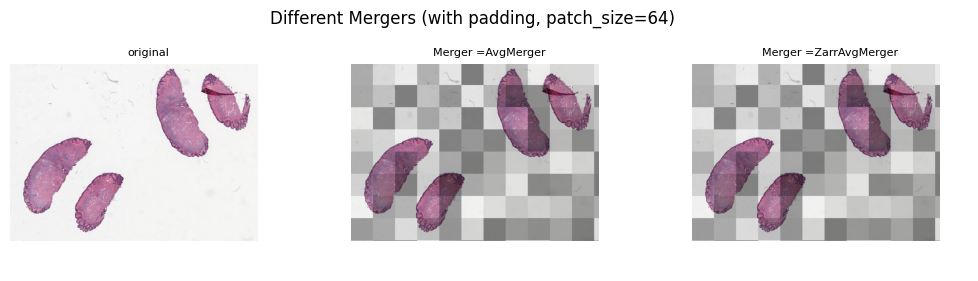

In [11]:
patch_size = 64
mergers = [AvgMerger, ZarrAvgMerger]
nrows = 1
ncols = len(mergers) + 1
figsize = (4 * ncols + 1, 3 * nrows)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
fig.subplots_adjust(wspace=0.05, top=0.8)
wsi_plot(axes[0], WSI_IMAGE)
axes[0].set_title("original", fontsize=8)
for i, merger in enumerate(mergers, start=1):
    inferer = PatchInferer(
        splitter=WSISlidingWindowSplitter(
            patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=WSI_LEVEL
        ),
        merger_cls=merger,
        match_spatial_shape=True,
    )
    img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)
    wsi_plot(axes[i], img[0])
    axes[i].set_title(f"Merger ={merger.__name__}", fontsize=8)

fig.suptitle(f"Different Mergers (with padding, {patch_size=})", fontsize=12)

### Zarr array information
Zarr arrays are stored in chunks and each chunk is usually compressed. We can get these information from the zarr array.

In [12]:
zarr_img = img[0]
print("Shape:", zarr_img.shape)
print("Chunk size:", zarr_img.chunks)
print("Number of chunk splits:", zarr_img.cdata_shape)
print("Total number of chunks:", zarr_img.nchunks)
print("Chunk compressor:", zarr_img.compressor)

Shape: (1, 3, 514, 718)
Chunk size: (1, 1, 288, 384)
Number of chunk splits: (1, 3, 2, 2)
Total number of chunks: 12
Chunk compressor: Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)


Also looking at the directory that the array is saved, we can see each chunk is saved in a separate file and named according to the chunk number in each direction. For instance here, we have four dimensions (with `(1, 3, 2, 2)` chunks in each dimension) so the name of each chunk has four parts separated by a dot where each part enumerates the chunk split in that direction.

In [13]:
zarr_path = zarr_img.store.path
print("Zarr image path:", zarr_path)
print("Zarr image directory contents:")
print("\n".join(sorted(os.listdir(zarr_path))))

Zarr image path: /Users/bhashemian/workspace/project-monai/tutorials/patch_inferer/merged.zarr
Zarr image directory contents:
.zarray
0.0.0.0
0.0.0.1
0.0.1.0
0.0.1.1
0.1.0.0
0.1.0.1
0.1.1.0
0.1.1.1
0.2.0.0
0.2.0.1
0.2.1.0
0.2.1.1


`.zarray` file contains the metadata of the zarr array, including the shape, dtype, chunks, etc.

In [14]:
!cat merged.zarr/.zarray

{
    "chunks": [
        1,
        1,
        288,
        384
    ],
    "compressor": {
        "blocksize": 0,
        "clevel": 5,
        "cname": "lz4",
        "id": "blosc",
        "shuffle": 1
    },
    "dtype": "<f4",
    "fill_value": null,
    "filters": null,
    "order": "C",
    "shape": [
        1,
        3,
        514,
        718
    ],
    "zarr_format": 2
}

### Use different Zarr storages

Depending on the use case, one might need to use different storages for Zarr arrays to optimize their performance. This can be easily achieved by passing the desired supported Zarr storage to `store`, `value_store`, and `count_store` to change the storage of the final merged output, temporary value accumulator, and temporary sample counter respectively. You can find the list of available storages here: https://zarr.readthedocs.io/en/stable/api/storage.html

In [15]:
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=WSI_LEVEL),
    merger_cls=ZarrAvgMerger,
    match_spatial_shape=True,
    store=zarr.storage.ZipStore("merged_output.zip", mode="w"),  # zip file
    value_store=zarr.storage.TempStore(),  # temp file
    count_store=zarr.storage.MemoryStore(),  # memory
)
img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)

/opt/homebrew/Cellar/python@3.11/3.11.4/Frameworks/Python.framework/Versions/3.11/lib/python3.11/zipfile.py:1550: UserWarning: Duplicate name: '.zarray'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


### Use different Zarr compressors

Zarr arrays support various compressors, such as Blosc, Zlib, LZ4, etc. For the the full list of available compressors, please check https://numcodecs.readthedocs.io/en/stable/index.html, or run `zarr.codec_registry`.
We can specify the compressor to use when creating the merger separately for each of the Zarr arrays (merged output, value accumulator, and sample counter). By default, the compressor for merged output array is `Blosc` and the temporary arrays are uncompressed (set to `None`). You can set any of the available compressors independently for those arrays.

In [16]:
inferer = PatchInferer(
    splitter=WSISlidingWindowSplitter(patch_size=patch_size, pad_mode="constant", reader=WSI_BACKEND, level=WSI_LEVEL),
    merger_cls=ZarrAvgMerger,
    match_spatial_shape=True,
    compressor=zarr.codec_registry["lz4"](),
    value_compressor=zarr.codec_registry["zlib"](),
    count_compressor=None,
)
img = run_inference(inferer, network_random_brightness, WSI_PATH_LIST)

In [17]:
print("List of available chunk compressors:")
print("\n".join(sorted(zarr.codec_registry.keys())))

List of available chunk compressors:
adler32
astype
base64
bitround
blosc
bz2
categorize
crc32
delta
fixedscaleoffset
gzip
json2
lz4
lzma
n5_wrapper
packbits
pickle
quantize
shuffle
vlen-array
vlen-bytes
vlen-utf8
zlib
zstd
